<a href="https://colab.research.google.com/github/dhaniyapatta/ecog-joystick/blob/main/connectivity_ecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os, requests

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)


# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet
!pip install mne --quiet
!pip install mne_connectivity --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
import numpy as np
from nilearn import plotting
from nimare import utils

import mne
# For elimiating warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import mne.viz
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity

alldat = np.load(fname, allow_pickle=True)['dat']



rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00


Subjet Chosen: 1
Creating RawArray with float64 data, n_channels=64, n_times=246440
    Range : 0 ... 246439 =      0.000 ...   246.439 secs
Ready.


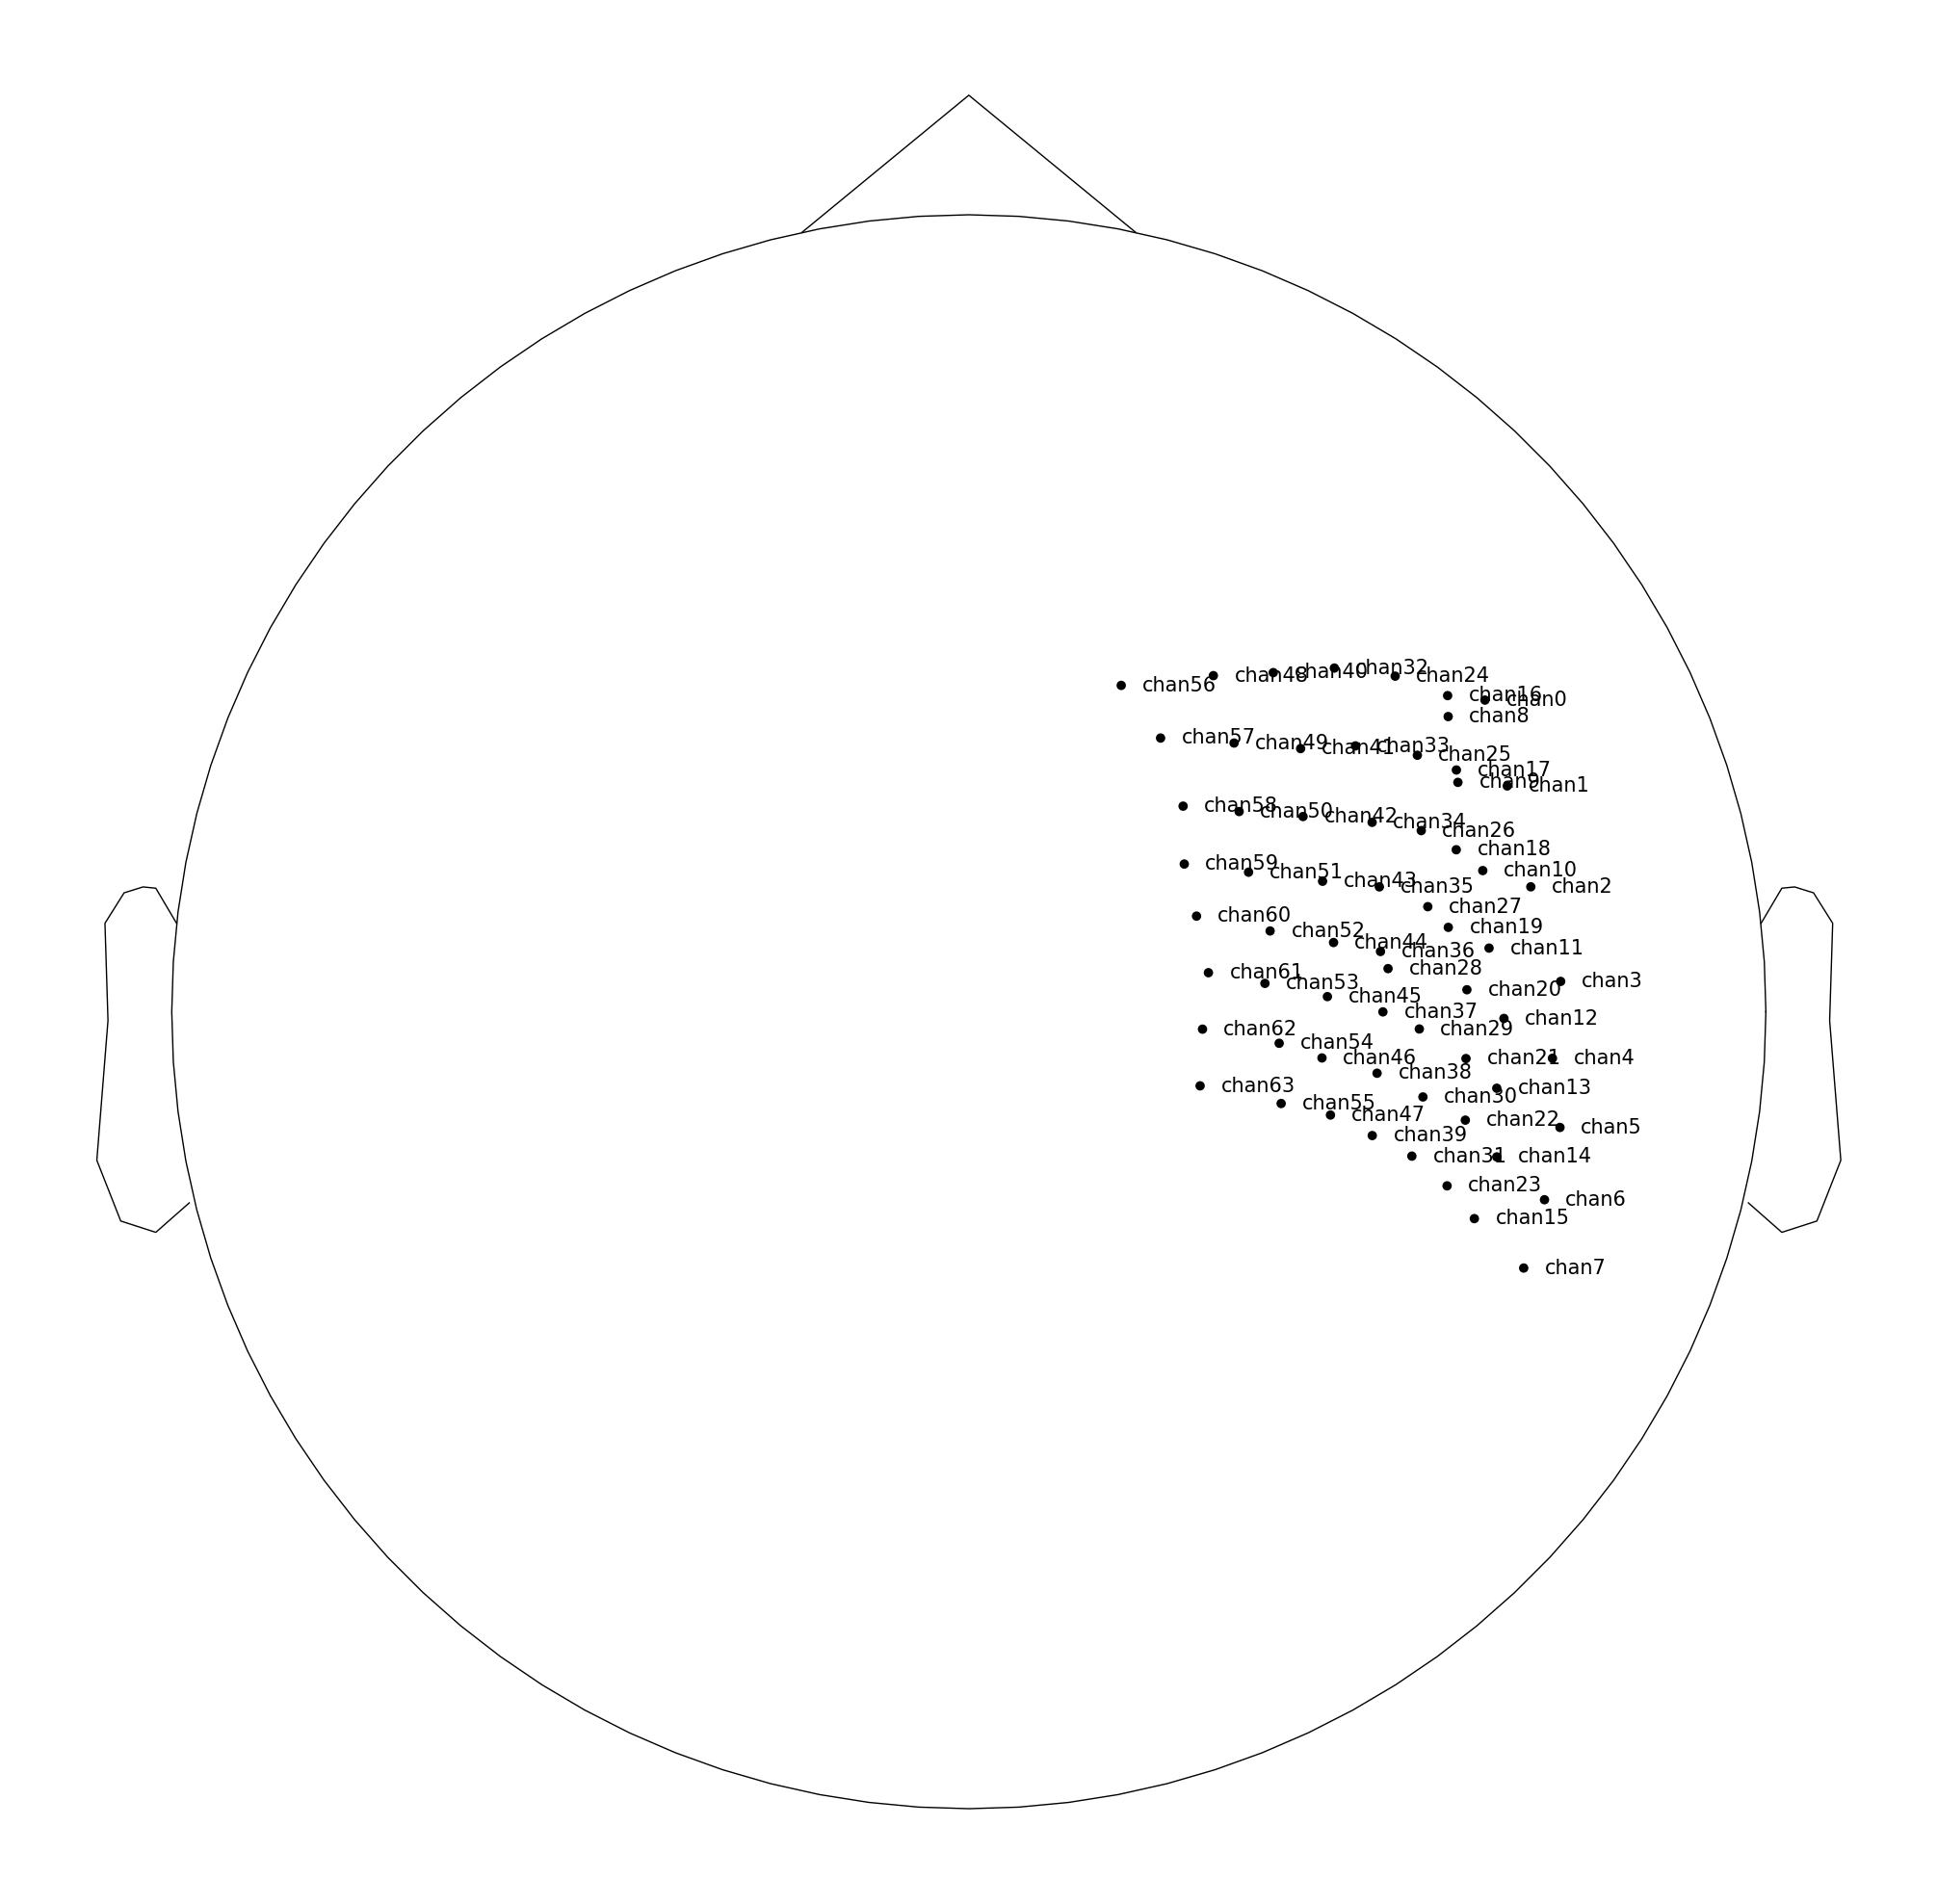

<Info | 8 non-empty values
 bads: []
 ch_names: chan0, chan1, chan2, chan3, chan4, chan5, chan6, chan7, chan8, ...
 chs: 64 ECoG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>


In [2]:
subjID = 1 #@param {type:"number"}
print("Subjet Chosen:", subjID)
subj=alldat[0][subjID] #data contains data for the subject
subj_name = str('subject '+ str(subjID))

V = subj['V'].astype('float32')
targetX = subj['targetX'].flatten()   # np array 1D
targetY = subj['targetY'].flatten()   # np array 1D
cursorX = subj['cursorX'].flatten()   # np array 1D
cursorY = subj['cursorY'].flatten()   # np array 1D
locs    = subj['locs']                # [[a1 b1 c1] [a2 b2 c2] ... [a60 b60 c60]]
hemisphere = subj['hemisphere']       # list of strings
lobe = subj['lobe']                   # ...
gyrus = subj['gyrus']                 # ...
Brodmann_Area = subj['Brodmann_Area'] # ...

for i in range(len(targetX)):
  if targetX[i]==np.max(targetX):
    start_index=i
    break

targetX = targetX[start_index:]
targetY=targetY[start_index:]
cursorX = cursorX[start_index:]
cursorY
V = V[start_index:]

data = V.T
n_channels = V.shape[1]
sampling_freq = 1000  # in Hertz
ch_types = ['ecog']*n_channels
ch_names = ['chan'+str(channel) for channel in list(range(n_channels))]

info = mne.create_info(ch_names, sfreq=sampling_freq, ch_types='ecog', verbose=None)

raw = mne.io.RawArray(data, info)




channel_names = ch_names
channel_coords = locs

# Ensure the channel coordinates are in meters
channel_coords_meters = channel_coords / 1000.0  # Convert mm to meters if needed

# Create a dictionary mapping channel names to coordinates
montage_dict = dict(zip(channel_names, channel_coords_meters))

# Create the montage
montage = mne.channels.make_dig_montage(ch_pos=montage_dict, coord_frame='head', )

# Set he montage to the raw data
raw.set_montage(montage)

# Verify by plotting sensor locations
raw.plot_sensors(kind='topomap', show_names=True)

print(raw.info)

In [5]:
epochs = mne.make_fixed_length_epochs(raw, duration=1.5, preload=False)

Not setting metadata
164 matching events found
No baseline correction applied
0 projection items activated


In [6]:
sfreq = epochs.info["sfreq"]  # the sampling frequency
tmin = 0.0  # exclude the baseline period for connectivity estimation
Freq_Bands = {"theta": [4.0, 8.0]}  # frequency of interest
n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# Prepare the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# We specify the connectivity measurements
connectivity_methods = ["wpli"]
n_con_methods = len(connectivity_methods)

# Compute connectivity over trials
con_epochs = spectral_connectivity_epochs(
    epochs,
    method=connectivity_methods,
    sfreq=sfreq,
    mode="cwt_morlet",
    cwt_freqs=freqs,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    tmin=tmin,
    cwt_n_cycles=4,
)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=0.000s..1.499s for estimation (1500 points)
    frequencies: 4.0Hz..8.0Hz (17 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 11


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 12


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 13


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 14


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 15


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 16


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 17


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 18


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 19


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 20


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 21


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 22


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 23


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 24


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 25


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 26


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 27


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 28


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 29


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 30


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 31


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 32


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 33


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 34


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 35


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 36


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 37


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 38


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 39


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 40


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 41


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 42


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 43


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 44


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 45


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 46


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 47


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 48


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 49


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 50


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 51


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 52


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 53


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 54


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 55


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 56


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 57


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 58


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 59


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 60


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 61


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 62


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 63


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 64


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 65


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 66


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 67


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 68


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 69


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 70


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 71


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 72


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 73


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 74


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 75


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 76


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 77


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 78


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 79


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 80


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 81


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 82


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 83


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 84


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 85


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 86


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 87


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 88


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 89


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 90


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 91


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 92


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 93


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 94


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 95


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 96


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 97


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 98


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 99


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 100


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 101


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 102


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 103


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 104


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 105


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 106


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 107


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 108


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 109


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 110


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 111


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 112


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 113


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 114


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 115


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 116


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 117


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 118


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 119


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 120


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 121


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 122


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 123


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 124


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 125


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 126


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 127


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 128


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 129


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 130


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 131


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 132


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 133


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 134


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 135


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 136


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 137


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 138


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 139


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 140


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 141


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 142


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 143


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 144


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 145


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 146


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 147


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 148


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 149


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 150


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 151


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 152


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 153


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 154


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 155


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 156


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 157


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 158


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 159


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 160


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 161


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 162


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 163


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 164


<ipython-input-6-95208ce18454>:19: UserWarning: At least one of the wavelets (1591) is longer than the signal (1500). Consider using a longer signal or shorter wavelets.
  con_epochs = spectral_connectivity_epochs(


    assembling connectivity matrix
[Connectivity computation done]


Global theta wPLI peaks 0.124s after stimulus


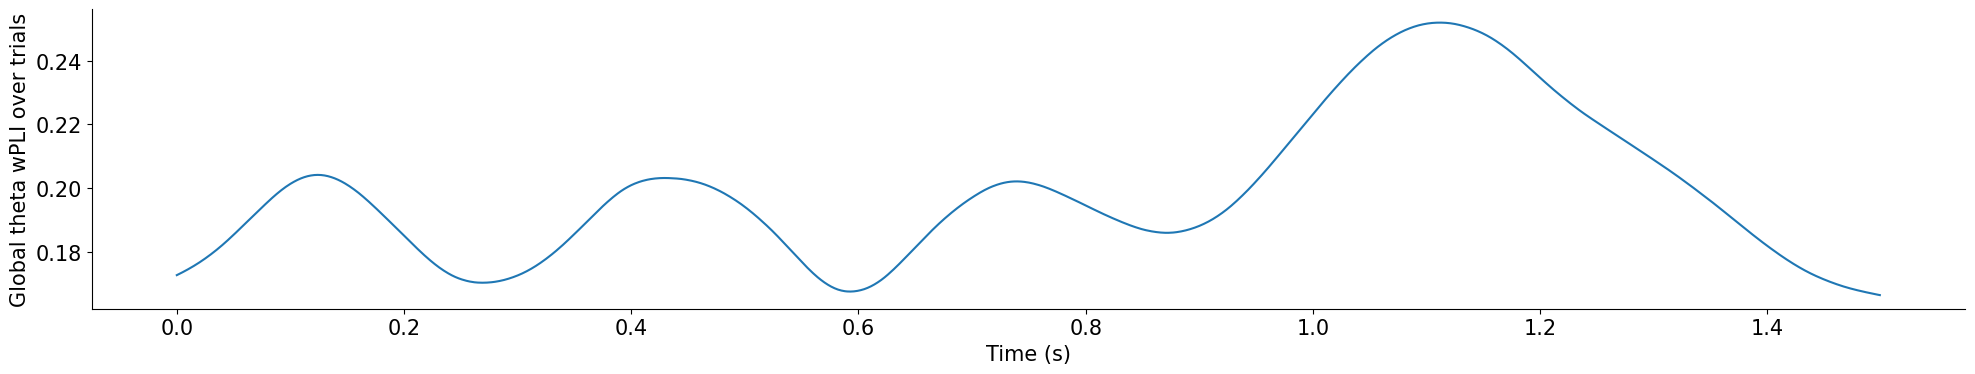

In [7]:
# Plot the global connectivity over time
n_channels = epochs.info["nchan"]  # get number of channels
times = epochs.times[epochs.times >= tmin]  # get the timepoints
n_connections = (n_channels * n_channels - n_channels) / 2

# Get global avg connectivity over all connections
con_epochs_raveled_array = con_epochs.get_data(output="raveled")
global_con_epochs = np.sum(con_epochs_raveled_array, axis=0) / n_connections

# Since there is only one freq band, we choose the first dimension
global_con_epochs = global_con_epochs[0]

fig = plt.figure()
plt.plot(times, global_con_epochs)
plt.xlabel("Time (s)")
plt.ylabel("Global theta wPLI over trials")

# Get the timepoint with highest global connectivity right after stimulus
t_con_max = np.argmax(global_con_epochs[times <= 0.5])
print(f"Global theta wPLI peaks {times[t_con_max]:.3f}s after stimulus")

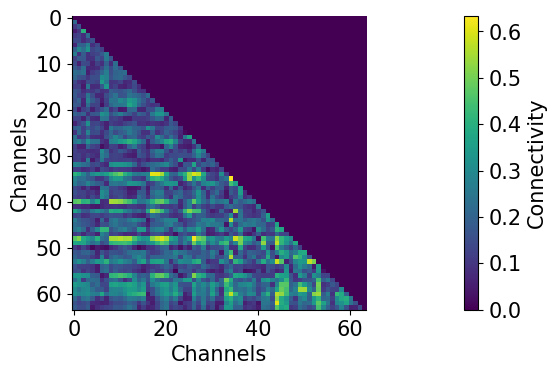

Using notebook 3d backend.



RuntimeError: Using the notebook backend on Linux requires a compatible VTK setup. Consider using Xfvb or xvfb-run to set up a working virtual display, or install VTK with OSMesa enabled.

In [10]:
# Plot the connectivity matrix at the timepoint with highest global wPLI
con_epochs_matrix = con_epochs.get_data(output="dense")[:, :, 0, t_con_max]

fig = plt.figure()
im = plt.imshow(con_epochs_matrix)
fig.colorbar(im, label="Connectivity")
plt.ylabel("Channels")
plt.xlabel("Channels")
plt.show()

# Visualize top 20 connections in 3D
plot_sensors_connectivity(epochs.info, con_epochs_matrix)

In [9]:
!pip install pyvistaqt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 5.1 MB/s eta 0:00:00
